In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

import numpy as np
import tables

import cascade_ode as code
import init_ode

import earth

# Helper functions definitions

In [2]:
gamma = 2 #spectral index of incoming neutrino flux
flavor = -3 # 1 = nu_e, 2= nu_mu, 3= nu_tau. Negative for antineutrinos
Na = 6.0221415e23

In [3]:
def get_att_ode(flavor,g,zenith,E,h5_filename,prefactor=1e70,relerr=1e-4):
    theta = np.pi - zenith
    logE = np.log10(E)
    r_e = np.ones(len(E))
    r_mu = r_e
    r_tau = r_e
    tau = np.zeros(E.shape)
    if zenith <= np.pi/2:
        return r_e, r_mu, r_tau, tau
    elif zenith > np.pi:
        raise ValueError('Unphysical zenith angle, must be in between 90 and 180!')
    [RHSMatrix,energy_nodes,energy_tau] = init_ode.init(flavor,h5_filename)
    NumNodes = len(energy_nodes)
    NumTau = len(energy_tau)
    phi_nu = energy_nodes**(2 - g)
    #need a prefactor to avoid negative solutions, default value works for
    #g<=4, increase it if you want sofer spectrum

    phi_0 = np.concatenate((phi_nu, phi_nu, phi_nu, np.zeros(NumTau)),axis=0)*prefactor
    phi_out = code.cascade(theta,phi_0,RHSMatrix,energy_nodes,energy_tau,relerr)
    att_nue = phi_out[0:NumNodes]/phi_0[0:NumNodes]
    att_numu = phi_out[NumNodes:2*NumNodes]/phi_0[NumNodes:2*NumNodes]
    att_nutau = phi_out[2*NumNodes:3*NumNodes]/phi_0[2*NumNodes:3*NumNodes]
    att_tau = phi_out[3*NumNodes:]/energy_tau**2
    r_e = np.interp(logE,np.log10(energy_nodes),att_nue)
    r_mu = np.interp(logE,np.log10(energy_nodes),att_numu)
    r_tau = np.interp(logE,np.log10(energy_nodes),att_nutau)
    tau = np.interp(logE,np.log10(energy_tau), att_tau)/prefactor
    return r_e, r_mu, r_tau, tau

# Example Earth attenuation for single flavor and zenith

In [4]:
zenith = np.radians(95.)
#prefactor to avoid negative solutions, absent to use default value 1e60
prefactor = 1e70
#relative error of the solutions, absent to use default value 1e-4
relerr = 1e-3
E=np.logspace(3,10,500)
h5_filename = '../../resources/NuFATECrossSections.h5'

[r_e,r_mu,r_tau,tau]=get_att_ode(flavor,gamma,zenith,E,h5_filename,prefactor,relerr)

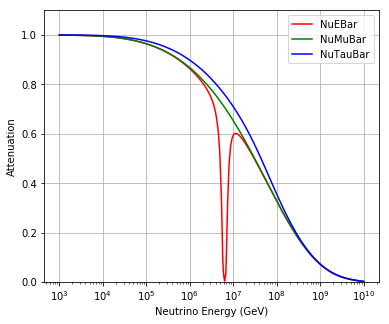

In [5]:
plt.figure(figsize=(6,5))
plt.semilogx(E,r_e,c='r')
plt.semilogx(E,r_mu,c='g')
plt.semilogx(E,r_tau,c='b')
plt.xlabel(r"Neutrino Energy (GeV)")
plt.ylim(0.,1.1)
plt.ylabel(r"Attenuation")
plt.legend(["NuEBar", "NuMuBar", "NuTauBar"])
plt.grid()

# Compare with nuFATE

In [6]:
import cascade as cas
flavor = -3
w,v,ci,energy_nodes,phi_0 = cas.get_eigs(flavor,gamma, "../../resources/NuFATECrossSections.h5")
Na = 6.0221415e23
t = earth.get_t_earth(zenith)*Na
phisol = np.dot(v,(ci*np.exp(w*t)))/phi_0

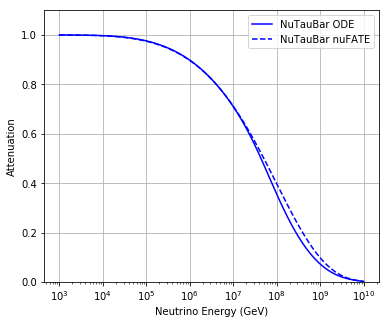

In [7]:
plt.figure(figsize=(6,5))
plt.semilogx(E, r_tau, c='b',linestyle='-')
plt.semilogx(energy_nodes, phisol,c='b',linestyle='--')
plt.xlabel(r"Neutrino Energy (GeV)")
plt.ylim(0.,1.1)
plt.ylabel(r"Attenuation")
plt.legend(["NuTauBar ODE", "NuTauBar nuFATE"])
plt.grid()